Why SPY
1. Volatility is high
2. Low Fees
3. Cheaper than SPX

Considerations
1. Using different markets for predicting SPY
2. Markets used
Asian
    1. AORD - AUS
    2. HSI - HK
    3. Nikkei - Japan
EU
    1. CAC40 - France
    2. DAX - Germany
US
    1. SPY
    2. S&P 500
    3. Nasdaq
    4. DJI

In [3]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [4]:
aord = pd.read_csv('ALLOrdinary.csv')
nikkei = pd.read_csv('Nikkei225.csv').ffill() 
# Forward fill to handle missing data by filling with the last available value
hsi = pd.read_csv('HSI.csv')
daxi= pd.read_csv('DAXI.csv')
cac40 = pd.read_csv('CAC40.csv')
sp500 = pd.read_csv('SP500.csv')
nasdaq = pd.read_csv('nasdaq_composite.csv')
spy = pd.read_csv('SPY.csv')
dji = pd.read_csv('DJI.csv')

# Adj Close is the adjusted closing price that has been amended to include any disputions or corporate actions

$$ y = b_0 + b_1x_1 + b_2x_2 + b_3x_3 + ...$$

Goal: Build a model to predict the Open Price of Tmr using the price of today

Response Variable: Open Next Day - Open (Tmr's Open - Tdy's Open)
Predictors:
1. US: Open - Open Price of Last Day -> Finds the range of yesterday
2. EU: Open - Open Last Day (Price at noon - minus open price -> For intraday Data)
3. Asian: Close - Open -> We want the range of the day

In [5]:
tspy = pd.DataFrame(index = spy.index) # Generates the index column (Numbering) to match SPY DF

# US Markets
tspy['spy'] = spy['Open'].shift(-1) - spy['Open'] # Daily Returns of SPY, Dates arranges from Oldest to Newest
tspy['spy_lagging'] = tspy['spy'].shift(1) # Lagging SPY Daily Returns
tspy['dji'] = dji['Open'] - dji['Open'].shift(1)
tspy['nasdaq'] = nasdaq['Open'] - nasdaq['Open'].shift(1)
tspy['sp500'] = sp500['Open'] - sp500['Open'].shift(1)

# EU Markets
tspy['daxi'] = daxi['Open'] - daxi['Open'].shift(1)
tspy['cac40'] = cac40['Open'] - cac40['Open'].shift(1)

# Asian Markets
tspy['aord'] = aord['Close'] - aord['Open']
tspy['nikkei'] = nikkei['Close'] - nikkei['Open']
tspy['hsi'] = hsi['Close'] - hsi['Open']

tspy['price'] = spy['Open'] # Used for backtesting

In [6]:
tspy.isnull().sum()

spy             1
spy_lagging     1
dji             1
nasdaq          1
sp500           1
daxi           11
cac40           3
aord            2
nikkei         57
hsi            57
price           0
dtype: int64

In [7]:
tspy = tspy.ffill() # Propogates the last valid observation forward to next valid
tspy = tspy.dropna()

tspy.isnull().sum() # Check for any null values
tspy.to_csv('tspy.csv') # Save the DataFrame to a CSV file

tspy.shape # 2678 days of data to backtest

(2678, 11)

In [8]:
train_tspy = tspy.iloc[-2000:-1000,:] # last 2000 to last 1000 days, selects all columns
test_tspy = tspy.iloc[-1000:,:] # Takes
print(train_tspy.shape,test_tspy.shape)

(1000, 11) (1000, 11)


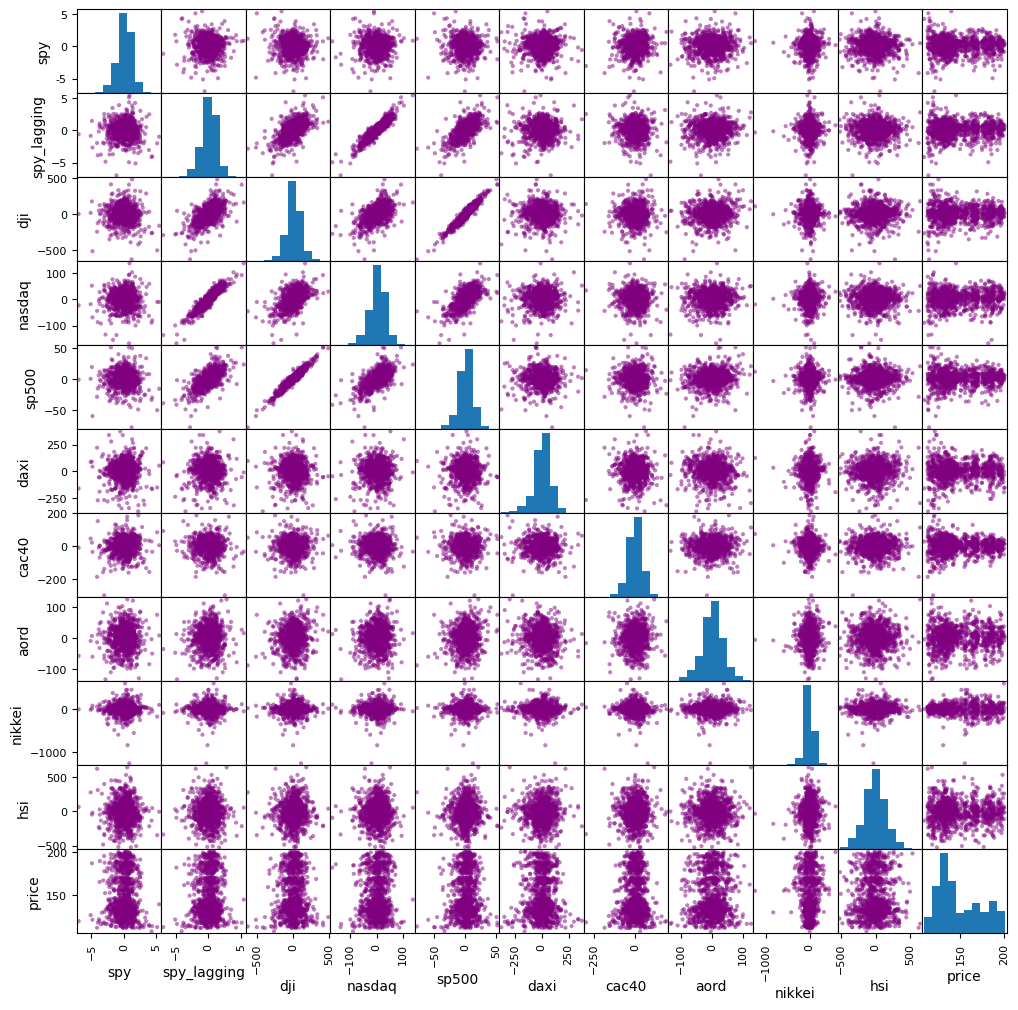

In [9]:
from pandas.plotting import scatter_matrix
sm = scatter_matrix(train_tspy, figsize=(12,12), color='purple')

In [10]:
train_tspy.iloc[:,:-1].corr()['spy'] 
# Select all rows and all columns except the last one and compute the correlation with the 'spy' column

spy            1.000000
spy_lagging   -0.011623
dji           -0.037097
nasdaq         0.012333
sp500         -0.018632
daxi           0.019410
cac40          0.076886
aord           0.048200
nikkei         0.035379
hsi           -0.038361
Name: spy, dtype: float64

In [11]:
import statsmodels.formula.api as smf

formula = 'spy ~ spy_lagging + dji + nasdaq + sp500 + aord + nikkei + hsi + daxi + cac40' # Regression formula
lm = smf.ols(formula=formula, data=train_tspy).fit() # Fit the model
lm.summary() # Print the summary of the regression model

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    spy   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     2.133
Date:                Sun, 11 May 2025   Prob (F-statistic):             0.0245
Time:                        00:11:23   Log-Likelihood:                -1643.1
No. Observations:                1000   AIC:                             3306.
Df Residuals:                     990   BIC:                             3355.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0798      0.040      1.993      0.047       0.001       0.158
spy_lagging    -0.1233      0.092     -1.340      0.180      -0.304       0.057
dji            -0.0023      0.001     -1.588      0.113      -0.005       0.001
nasdaq          0.0047      0.004      1.240      0.215      -0.003       0.012
sp500           0.0178      0.014      1.273      0.203      -0.010       0.045
aord            0.0017      0.001      1.497      0.135      -0.001       0.004
nikkei          0.0004      0.000      1.293      0.196      -0.000       0.001
hsi            -0.0003      0.000     -1.412      0.158      -0.001       0.000
daxi            0.0003      0.000      0.724      0.469      -0.001       0.001
cac40           0.0021      0.001      2.485      0.013       0.000       0.004
==============================================================================
Omnibus:                       85.811   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              235.379
Skew:                          -0.444   Prob(JB):                     7.73e-52
Kurtosis:                       5.205   Cond. No.                         385.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [12]:
train_tspy.iloc[:, :-1].corr()
# Multicllinearity -> Situation where two or more predicts are highly correlated with substancial accuracy. Correlation
# change drastically with small changes in the data.

,spy,spy_lagging,dji,nasdaq,sp500,daxi,cac40,aord,nikkei,hsi
spy,1.000000,-0.011623,-0.037097,0.012333,-0.018632,0.019410,0.076886,0.048200,0.035379,-0.038361
spy_lagging,-0.011623,1.000000,0.575321,0.932118,0.664272,0.030278,-0.035791,0.039616,0.013315,-0.015703
dji,-0.037097,0.575321,1.000000,0.517313,0.960032,-0.010432,0.008134,0.119396,0.003770,0.026176
nasdaq,0.012333,0.932118,0.517313,1.000000,0.636528,0.040097,-0.023789,0.049933,0.006210,-0.003305
sp500,-0.018632,0.664272,0.960032,0.636528,1.000000,0.000139,0.004462,0.127922,0.004431,0.028705
daxi,0.019410,0.030278,-0.010432,0.040097,0.000139,1.000000,-0.015331,-0.080747,0.004546,0.038492
cac40,0.076886,-0.035791,0.008134,-0.023789,0.004462,-0.015331,1.000000,0.027647,-0.054148,0.026072
aord,0.048200,0.039616,0.119396,0.049933,0.127922,-0.080747,0.027647,1.000000,0.024909,0.010722
nikkei,0.035379,0.013315,0.003770,0.006210,0.004431,0.004546,-0.054148,0.024909,1.000000,0.035837
hsi,-0.038361,-0.015703,0.026176,-0.003305,0.028705,0.038492,0.026072,0.010722,0.035837,1.000000


C:\Users\yeodi\AppData\Local\Temp\ipykernel_21708\2628788042.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_tspy['PredictedY'] = lm.predict(train_tspy) # Predict the values using the model
C:\Users\yeodi\AppData\Local\Temp\ipykernel_21708\2628788042.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_tspy['PredictedY'] = lm.predict(test_tspy) # Predict the values using the model


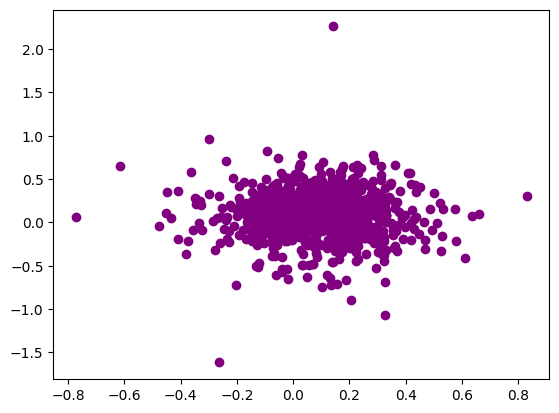

In [13]:
train_tspy['PredictedY'] = lm.predict(train_tspy) # Predict the values using the model
test_tspy['PredictedY'] = lm.predict(test_tspy) # Predict the values using the model
plt.scatter(train_tspy['PredictedY'], test_tspy['PredictedY'], color='purple') # Scatter plot of predicted vs actual values

# Model Evaluation using RMSE and Adjusted R-squared
 -> Create Function where parameter model is model and model k is the number of predictors. yname is the column name of our response variable



In [17]:
def adjustedMetric(data, model, model_k, yname):
    data['yhat'] = model.predict(data)
    SST = ((data[yname] - data[yname].mean())**2).sum() # Total sum of squares
    SSR = ((data['yhat'] - data[yname].mean())**2).sum() # Residual sum of squares
    SSE = ((data[yname] - data['yhat'])**2).sum() # Error sum of squares
    r2 = SSR/SST # R-squared
    adjustr2 = 1 - (1-r2) * (data.shape[0]-1)/(data.shape[0]-model_k-1) # Adjusted R-squared
    RMSE = (SSE/(data.shape[0] - model_k - 1)) ** 0.5 # Root mean square error
    return adjustr2, RMSE


In [ ]:
print("Adjusted R2 and RMSE for Train Data:"), adjustedMetric(train_tspy, lm, 9, 'spy')
print("Adjusted R2 and RMSE for Test Data:"), adjustedMetric(test_tspy, lm, 9, 'spy')

In [23]:
def AssessTable(test, train, model, model_k, yname):
    r2test, RMSEtest = adjustedMetric(test, model, model_k, yname)
    r2train, RMSEtrain = adjustedMetric(train, model, model_k, yname)
    assessment = pd.DataFrame(index=['R2', 'RMSE'], columns=['Train', 'Test'])
    assessment['Train'] = [r2train, RMSEtrain]
    assessment['Test'] = [r2test, RMSEtest]
    return assessment

In [24]:
AssessTable(test_tspy, train_tspy, lm, 9, 'spy')

C:\Users\yeodi\AppData\Local\Temp\ipykernel_21708\1681947918.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['yhat'] = model.predict(data)
C:\Users\yeodi\AppData\Local\Temp\ipykernel_21708\1681947918.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['yhat'] = model.predict(data)


,Train,Test
R2,0.010102,0.013609
RMSE,1.257534,1.759693


# Implementing the Model

In [26]:
import warnings
warnings.filterwarnings('ignore')

indicepanel = pd.read_csv('indicepanel.csv')

In [31]:
train = indicepanel.iloc[-2000:-1000,:]
test = indicepanel.iloc[-1000:,:]

formula = 'spy ~ spy_lag1 + dji + nasdaq + sp500 + aord + nikkei + hsi + daxi + cac40' # Regression formula
lm = smf.ols(formula=formula, data=train).fit() # Fit the model

In [34]:
train['PredictedY'] = lm.predict(train) # Predict the values using the model
test['PredictedY'] = lm.predict(test) # Predict the values using the model

In [36]:
# Train
train['order'] = [1 if sig > 0 else -1 for sig in train['PredictedY']]
train['profit'] = train['spy'] * train['order'] # Daily Returns

train['wealth'] = train['profit'].cumsum()
print("Total Profit for Train Data: ", train['wealth'].iloc[-1])

Total Profit for Train Data:  214.3400950000004


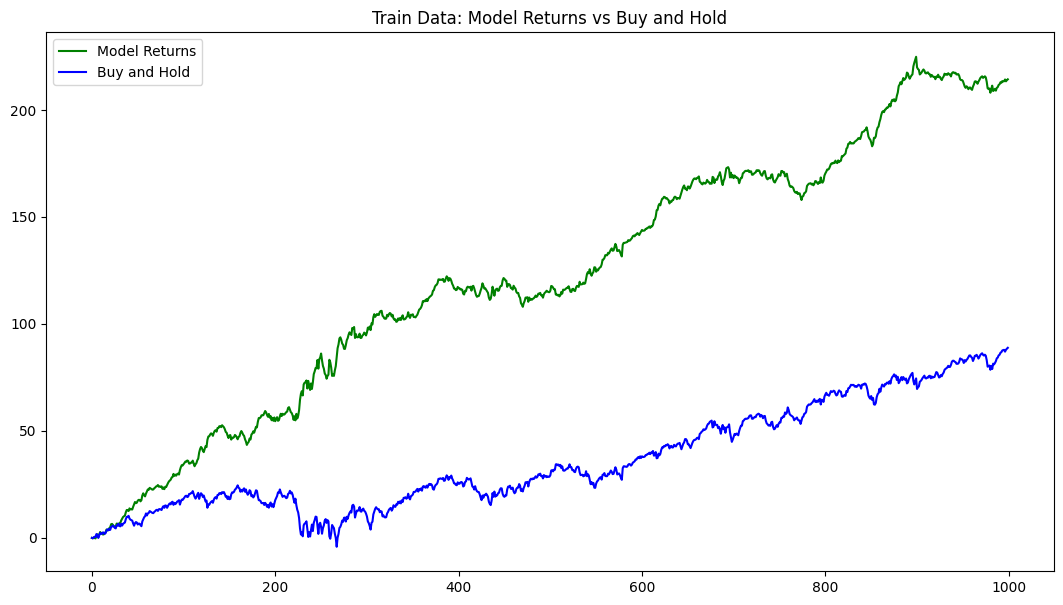

In [50]:
plt.figure(figsize=(13, 7))
plt.plot(train['profit'].cumsum().values, color='green', label='Model Returns')
plt.plot(train['spy'].cumsum().values, color='blue', label='Buy and Hold')
plt.title('Train Data: Model Returns vs Buy and Hold')
plt.legend()
plt.show()

Total Profit for Test Data:  241.0300879999996


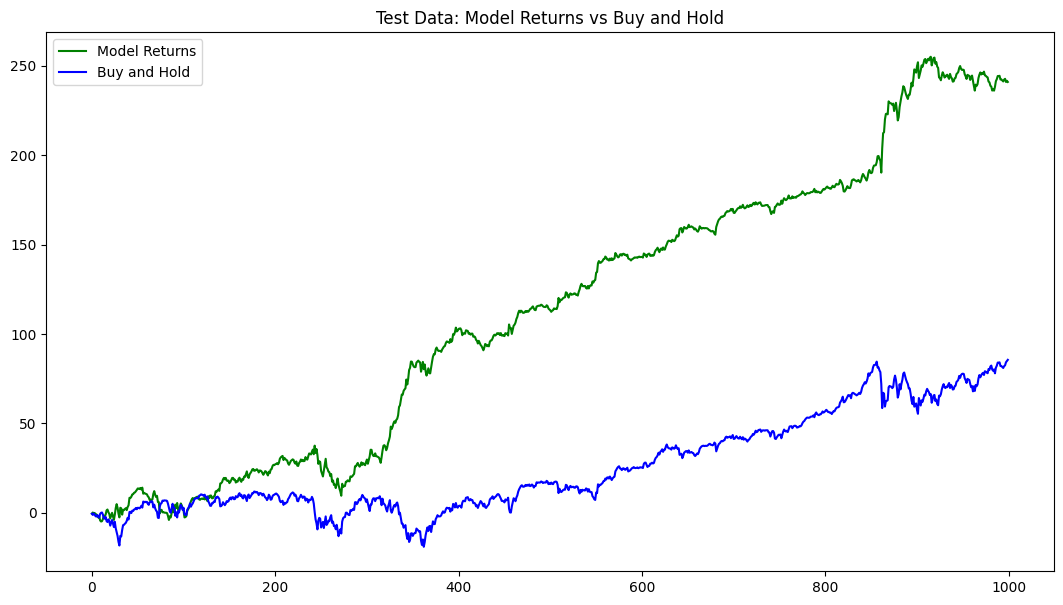

In [49]:
# Test
test['order'] = [1 if sig > 0 else -1 for sig in test['PredictedY']]
test['profit'] = test['spy'] * test['order'] # Daily Returns
test['wealth'] = test['profit'].cumsum()
print("Total Profit for Test Data: ", test['wealth'].iloc[-1])

plt.figure(figsize=(13, 7))
plt.plot(test['profit'].cumsum().values, color='green', label='Model Returns')
plt.plot(test['spy'].cumsum().values, color='blue', label='Buy and Hold')
plt.title('Test Data: Model Returns vs Buy and Hold')
plt.legend()
plt.show()

# Evaluating the Model Results
1. Sharpe Ratio
2. Maximum Drawdown

In [51]:
train['wealth'] = train['wealth'] + train.loc[train.index[0], 'Price']
test['wealth'] = test['wealth'] + train.loc[train.index[0], 'Price']

In [ ]:
train['return'] = np.log(train['wealth'] / train['wealth'].shift(1))
train_dailyr = train['return'].dropna()

print("Daily Sharpe Ratio: ", train_dailyr.mean() / train_dailyr.std(ddof=1))
print("Annualized Sharpe Ratio: ", ((train_dailyr.mean() * np.sqrt(252)) / train_dailyr.std(ddof=1)))

Daily Sharpe Ratio:  0.17965076303257985
Annualized Sharpe Ratio:  2.8518674509632134


In [55]:
test['return'] = np.log(test['wealth'] / test['wealth'].shift(1))
test_dailyr = test['return'].dropna()

print("Daily Sharpe Ratio: ", test_dailyr.mean() / test_dailyr.std(ddof=1))
print("Annualized Sharpe Ratio: ", ((test_dailyr.mean() * np.sqrt(252)) / test_dailyr.std(ddof=1)))

Daily Sharpe Ratio:  0.12061293936627684
Annualized Sharpe Ratio:  1.9146710547580859


In [59]:
# Maximum Drawdown in Train Data
train['peak'] = train['wealth'].cummax()
train['drawdown'] = ((train['peak'] - train['wealth'])/train['peak'])

print("Maximum Drawdown in Train Data: ", train['drawdown'].max())

Maximum Drawdown in Train Data:  0.06069016443644383


In [61]:
# Maximum Drawdown in Test Data
test['peak'] = test['wealth'].cummax()
test['drawdown'] = ((test['peak'] - test['wealth'])/test['peak'])
print("Maximum Drawdown in Test Data: ", test['drawdown'].max())

Maximum Drawdown in Test Data:  0.18653000856472496
